---

# **Tiểu luận kết thúc học phần**

---

## Thông tin

* Chủ đề: ***Dự báo nguy cơ vỡ nợ của doanh nghiệp dựa trên chỉ số Altman's $Z$-Score và hồi quy logistics***

* Học viên thực hiện: **NGUYỄN CÔNG HIẾU (524102110660)**

* Học phần: **Khoa học dữ liệu tài chính (25C1DAT60504501)**

---

## **Đọc dữ liệu và xử lý dữ liệu ban đầu**

In [1]:
import numpy as np
import pandas as pd

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)

In [3]:
pd.options.display.float_format = '{:.3f}'.format

### **Z-Score**

In [4]:
# Import dataset of Z-score factors
z = pd.read_excel('data/main/z.xlsx')
z.set_index(['Firm', 'Year'], inplace=True)
z.sort_index(inplace=True)
z.head()

Exchange  TotalAssets  TotalLiabilities  ShortTermDebts  \
Firm Year                                                           
A32  2010    UPCoM          NaN               NaN             NaN   
     2011    UPCoM          NaN               NaN             NaN   
     2012    UPCoM          NaN               NaN             NaN   
     2013    UPCoM          NaN               NaN             NaN   
     2014    UPCoM          NaN               NaN             NaN   

           LongTermDebts  CurrentAssets  CurrentLiabilities  \
Firm Year                                                     
A32  2010            NaN            NaN                 NaN   
     2011            NaN            NaN                 NaN   
     2012            NaN            NaN                 NaN   
     2013            NaN            NaN                 NaN   
     2014            NaN            NaN                 NaN   

           CashAndCashEquivalent  RetainedEarnings  EarningBeforeTax  \
Firm Year                                                              
A32  2010                    NaN               NaN               NaN   
     2011                    NaN               NaN               NaN   
     2012                    NaN               NaN               NaN   
     2013                    NaN               NaN               NaN   
     2014                    NaN               NaN               NaN   

           InterestExpense  MarketCapitalization  Sales  
Firm Year                                                
A32  2010              NaN                   NaN    NaN  
     2011              NaN                   NaN    NaN  
     2012              NaN                   NaN    NaN  
     2013              NaN                   NaN    NaN  
     2014              NaN                   NaN    NaN

In [5]:
# Calculate Z-Score components
z_factors = pd.DataFrame({
    'Exchange': z['Exchange'],
    'X1': (z['CurrentAssets'] - z['CurrentLiabilities']) / z['TotalAssets'],
    'X2': z['RetainedEarnings'] / z['TotalAssets'],
    'X3': (z['EarningBeforeTax'] - z['InterestExpense']) / z['TotalAssets'],
    'X4': z['MarketCapitalization'] / z['TotalLiabilities'],
    'X5': z['Sales'] / z['TotalAssets']
})

# Calculate Z-Score and Z classification
z_factors['Z-Score'] = (1.2 * z_factors['X1'] +
                       1.4 * z_factors['X2'] +
                       3.3 * z_factors['X3'] +
                       0.6 * z_factors['X4'] +
                       1.0 * z_factors['X5'])

# Z classification: 1 if Z-Score < 1.8 else 0
z_factors['Z'] = np.where(
    z_factors['Z-Score'].isna(),
    np.nan,
    np.where(z_factors['Z-Score'] >= 1.8, 0, 1)
)
z_factors.head()

Exchange  X1  X2  X3  X4  X5  Z-Score   Z
Firm Year                                          
A32  2010    UPCoM NaN NaN NaN NaN NaN      NaN NaN
     2011    UPCoM NaN NaN NaN NaN NaN      NaN NaN
     2012    UPCoM NaN NaN NaN NaN NaN      NaN NaN
     2013    UPCoM NaN NaN NaN NaN NaN      NaN NaN
     2014    UPCoM NaN NaN NaN NaN NaN      NaN NaN

### **Forecast Features**

In [6]:
# Import dataset of forecast features
features = pd.read_excel('data/main/factors.xlsx')
features.set_index(['Firm', 'Year'], inplace=True)
features.sort_index(inplace=True)
features.head()

Code Exchange  Sales  EarningAfterTax  TotalAssets  TotalEquity  \
Firm Year                                                                       
A32  2010  A322010    UPCoM    NaN              NaN          NaN          NaN   
     2011  A322011    UPCoM    NaN              NaN          NaN          NaN   
     2012  A322012    UPCoM    NaN              NaN          NaN          NaN   
     2013  A322013    UPCoM    NaN              NaN          NaN          NaN   
     2014  A322014    UPCoM    NaN              NaN          NaN          NaN   

           CurrentAssets  CurrentLiabilities  ShortTermDebts  LongTermDebts  \
Firm Year                                                                     
A32  2010            NaN                 NaN             NaN            NaN   
     2011            NaN                 NaN             NaN            NaN   
     2012            NaN                 NaN             NaN            NaN   
     2013            NaN                 NaN             NaN            NaN   
     2014            NaN                 NaN             NaN            NaN   

           ShortTermReceivable  LongTermReceivable  Inventory  Revenue  COGS  \
Firm Year                                                                      
A32  2010                  NaN                 NaN        NaN      NaN   NaN   
     2011                  NaN                 NaN        NaN      NaN   NaN   
     2012                  NaN                 NaN        NaN      NaN   NaN   
     2013                  NaN                 NaN        NaN      NaN   NaN   
     2014                  NaN                 NaN        NaN      NaN   NaN   

           PPE  MarketCapitalization  
Firm Year                             
A32  2010  NaN                   NaN  
     2011  NaN                   NaN  
     2012  NaN                   NaN  
     2013  NaN                   NaN  
     2014  NaN                   NaN

In [7]:
# Calculate forecast features
forecast_features = pd.DataFrame({
    'NPM':  features['EarningAfterTax'] / features['Sales'],
    'ROE':  features['EarningAfterTax'] / features['TotalEquity'],
    'QR':   (features['CurrentAssets'] - features['Inventory']) / features['CurrentLiabilities'],
    'DTE':  (features['TotalAssets'] - features['TotalEquity']) / features['TotalEquity'],
    'RTR':  features['Sales'] / ((features['ShortTermReceivable'] + features['LongTermReceivable'] 
                                  + features['ShortTermReceivable'].shift(1) + features['LongTermReceivable'].shift(1)) / 2),
    'ATR':  features['Sales'] / ((features['TotalAssets'] + features['TotalAssets'].shift(1)) / 2),
    'SIZE': np.log(features['MarketCapitalization']),
    'FAR':  features['PPE'] / features['TotalAssets']
})

# Clean infinite values
forecast_features.replace([np.inf, -np.inf], np.nan, inplace=True)
forecast_features.head()

NPM  ROE  QR  DTE  RTR  ATR  SIZE  FAR
Firm Year                                        
A32  2010  NaN  NaN NaN  NaN  NaN  NaN   NaN  NaN
     2011  NaN  NaN NaN  NaN  NaN  NaN   NaN  NaN
     2012  NaN  NaN NaN  NaN  NaN  NaN   NaN  NaN
     2013  NaN  NaN NaN  NaN  NaN  NaN   NaN  NaN
     2014  NaN  NaN NaN  NaN  NaN  NaN   NaN  NaN

### **Kết nối hai bảng dữ liệu và lọc dữ liệu**

In [8]:
# Merge Z-Score and forecast features
df = pd.merge(
    z_factors[['Exchange', 'Z-Score', 'Z']],
    forecast_features,
    left_index=True,
    right_index=True,
    how='inner'
)

df.dropna(inplace=True)
df.head()

Exchange  Z-Score     Z   NPM   ROE    QR   DTE   RTR   ATR   SIZE  \
Firm Year                                                                      
A32  2018    UPCoM    2.608 0.000 0.067 0.215 0.646 1.335 6.153 1.333 26.196   
     2019    UPCoM    2.929 0.000 0.068 0.210 0.555 0.945 8.234 1.530 25.839   
     2020    UPCoM    2.833 0.000 0.058 0.174 0.676 1.016 8.202 1.578 26.143   
     2021    UPCoM    2.317 0.000 0.053 0.145 0.724 1.215 5.553 1.279 26.106   
     2022    UPCoM    2.236 0.000 0.051 0.170 0.718 1.542 4.968 1.337 26.167   

            FAR  
Firm Year        
A32  2018 0.259  
     2019 0.286  
     2020 0.245  
     2021 0.216  
     2022 0.215

## **Thống kê mô tả**

In [9]:
# Omit firms listed on UPCoM exchange
# df = df[df['Exchange'] != 'UPCoM']

In [10]:
# Count number of firms by Exchange based on the latest year available

## First, retrieve the latest year for each firm
df_latest = df.reset_index().sort_values('Year').drop_duplicates(subset=['Firm'], keep='last')

# Then, count the number of firms by Exchange
count_latest = df_latest['Exchange'].value_counts()

# Display the counts
print(count_latest)

Exchange
UPCoM    855
HOSE     351
HNX      291
Name: count, dtype: int64


In [11]:
# Count number of firms by range of Z-Score for each year
## Define bins and labels
bins = [-np.inf, 1.8, 3, np.inf]
labels = ['High Risk', 'Grey Area', 'Low Risk']

# Classify Z-Score into ranges
df['Z-Score Range'] = pd.cut(df['Z-Score'], bins=bins, labels=labels)
count_by_year = df.groupby(['Year', 'Z-Score Range']).size().unstack(fill_value=0)
count_by_year['Total'] = count_by_year.sum(axis=1)

# Display the counts
print(count_by_year)

Z-Score Range  High Risk  Grey Area  Low Risk  Total
Year                                                
2010                 189        160       187    536
2011                 290        156       196    642
2012                 319        138       205    662
2013                 296        163       218    677
2014                 302        182       284    768
2015                 365        208       349    922
2016                 451        281       408   1140
2017                 494        307       416   1217
2018                 502        343       432   1277
2019                 541        325       437   1303
2020                 486        321       471   1278
2021                 472        343       546   1361
2022                 523        312       528   1363
2023                 540        286       542   1368
2024                 489        317       561   1367


In [12]:
# Descriptive statistics
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Z-Score,15881.000,3.521,24.664,-1398.710,1.255,2.261,3.930,1357.368
Z,15881.000,0.394,0.489,0.000,0.000,0.000,1.000,1.000
NPM,15881.000,-3.375,413.961,-51766.712,0.009,0.038,0.101,4922.179
ROE,15881.000,-0.050,15.314,-1908.428,0.025,0.088,0.163,186.272
QR,15881.000,2.067,6.223,0.001,0.610,0.990,1.791,384.841
DTE,15881.000,1.934,29.622,-1634.473,0.380,0.937,1.996,1891.871
RTR,15881.000,12.729,378.274,-0.981,1.765,4.122,8.671,44397.609
ATR,15881.000,1.160,1.397,-0.909,0.369,0.831,1.472,42.208
SIZE,15881.000,26.108,1.867,19.249,24.837,25.919,27.212,33.725
FAR,15881.000,0.222,0.225,0.000,0.048,0.143,0.320,0.986


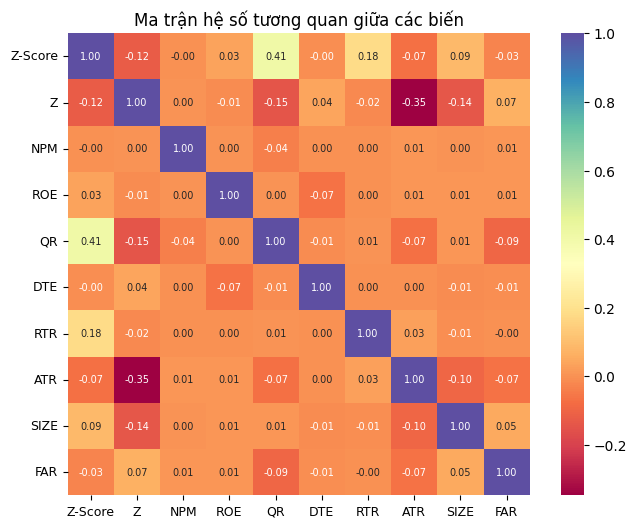

In [13]:
# Correlation matrix

# Calculate correlation matrix for numeric columns
corrmat = df.select_dtypes(include=[np.number]).corr()

# Use seaborn to create a heatmap
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
sns.heatmap(corrmat, annot=True, fmt=".2f", cmap='Spectral', square=True, annot_kws={"size": 7})
plt.xticks(fontsize=9)
plt.yticks(fontsize=9, rotation=0)
plt.title('Ma trận hệ số tương quan giữa các biến')
plt.show()

## **Thiết lập các hàm**

In [14]:
data = df.drop(['Exchange','Z-Score','Z-Score Range'], axis=1)
data.head()

Z   NPM   ROE    QR   DTE   RTR   ATR   SIZE   FAR
Firm Year                                                       
A32  2018 0.000 0.067 0.215 0.646 1.335 6.153 1.333 26.196 0.259
     2019 0.000 0.068 0.210 0.555 0.945 8.234 1.530 25.839 0.286
     2020 0.000 0.058 0.174 0.676 1.016 8.202 1.578 26.143 0.245
     2021 0.000 0.053 0.145 0.724 1.215 5.553 1.279 26.106 0.216
     2022 0.000 0.051 0.170 0.718 1.542 4.968 1.337 26.167 0.215

### **Hàm chia mẫu thành hai phần `training` và `testing`**

In [ ]:
def split_train_test(data, cutoff, cols_to_lag, lag=1):
    """
    Split data into training and testing sets.
    
    Parameters:
    data (DataFrame): Input DataFrame to be split.
    cutoff (int): Year to split the data.
    cols_to_lag (list): List of column names to create lagged features for.
    lags (int): Number of lagged periods to create.
    
    Returns:
    DataFrame, DataFrame: Two DataFrames representing the training and testing sets.
    """
    # Create lagged features
    all_lags = [data[['Z']]]

    # Calculate lags using loop
    for i in range(1, lag+1):
        data_lag = data.groupby(level='Firm')[cols_to_lag].shift(i)
        data_lag = data_lag.add_suffix(f'_L{i}')
        all_lags.append(data_lag)

    # Concatenate all lagged features
    data = pd.concat(all_lags, axis=1)
    data.dropna(inplace=True)

    # Split the data
    train = data[data.index.get_level_values('Year') <= cutoff].copy()
    test = data[data.index.get_level_values('Year') > cutoff].copy()
    return train, test

### **Thiết lập mô hình logit để đào tạo**

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score

In [ ]:
def train_and_test_model(data, target = 'Z', cutoff=2023, lag=1):
    """
    Train and test a logistic regression model.

    Parameters:
    data (DataFrame): Input DataFrame containing features and target variable.
    target (str): Name of the target variable column.
    cutoff (int): Year to split the data into training and testing sets.
    lag (int): Number of lagged periods to create.

    Returns:
    None
    """
    # Split data into training and testing sets
    col_names = data.columns.tolist()
    vars = [col for col in col_names if col != target and col != 'Exchange']
    train, test = split_train_test(data, cutoff=cutoff, cols_to_lag=vars, lag=lag)
    
    # Set up features variables
    features = [col for col in train.columns if col != target]

    # Set up X and y for training and testing
    X_train = train[features]
    y_train = train[target]
    X_test = test[features]
    y_test = test[target]

    # Standardize features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Initialize and train the model
    model = LogisticRegression(
        class_weight='balanced',
        max_iter=1000,
        random_state=42
    )

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    # Evaluate the model
    print('\n')
    print('============== KẾT QUẢ HUẤN LUYỆN MÔ HÌNH ================')
    print(f'Số lượng quan sát trong tập huấn luyện: {X_train.shape[0]}')
    print(f'Số lượng quan sát trong tập kiểm tra: {X_test.shape[0]}')
    print(f'Điểm cắt năm: {cutoff}')
    print(f'Số độ trễ được sử dụng: {lag}')
    print(f'Số lượng biến giải thích trong mô hình: {X_train.shape[1]}')

    print('\n==================== ĐÁNH GIÁ MÔ HÌNH ====================')
    print(f'Độ chính xác tổng thể (Accuracy): {accuracy_score(y_test, y_pred):.3f}')
    print(f'Độ chính xác trên tập huấn luyện (Train Accuracy): {model.score(X_train, y_train):.3f}')
    print(f'ROC-AUC Score: {roc_auc_score(y_test, y_proba):.3f}')

    print('\n======= BÁO CÁO PHÂN LOẠI (Classification Report) =======')
    print(classification_report(y_test, y_pred))

    print('========== MA TRẬN NHẦM LẪN (Confusion Matrix) ==========')
    conf_matrix = pd.DataFrame(
        confusion_matrix(y_test, y_pred),
        index = ['Thực tế = 0', 'Thực tế = 1'],
        columns = ['Dự báo = 0', 'Dự báo = 1']
    )
    print(conf_matrix)
    print('\n')

    return None

In [18]:
cutoff = [2020, 2021, 2022, 2023]
lags = [1, 2, 3]

for year in cutoff:
    for lag in lags:
        train_and_test_model(data, target='Z', cutoff=year, lag=lag)



============== KẾT QUẢ HUẤN LUYỆN MÔ HÌNH ================
Số lượng quan sát trong tập huấn luyện: 8995
Số lượng quan sát trong tập kiểm tra: 5389
Điểm cắt năm: 2020
Số độ trễ được sử dụng: 1
Số lượng biến giải thích trong mô hình: 8

==================== ĐÁNH GIÁ MÔ HÌNH ====================
Độ chính xác tổng thể (Accuracy): 0.771
Độ chính xác trên tập huấn luyện (Train Accuracy): 0.792
ROC-AUC Score: 0.859

======= BÁO CÁO PHÂN LOẠI (Classification Report) =======
              precision    recall  f1-score   support

         0.0       0.87      0.74      0.80      3389
         1.0       0.65      0.82      0.73      2000

    accuracy                           0.77      5389
   macro avg       0.76      0.78      0.76      5389
weighted avg       0.79      0.77      0.77      5389

========== MA TRẬN NHẦM LẪN (Confusion Matrix) ==========
             Dự báo = 0  Dự báo = 1
Thực tế = 0        2522         867
Thực tế = 1         366        1634




============== KẾT QUẢ HUẤN LU